## Loading and preparing the data

### Loading data

Let's start data analysis by importing all the libraries, modules, data structures and functions that we will need in the process of conducting this research. 

Additionally, here we will define several constant variables (distinguishable by capital letters), the values of which will be fixed:

* `TRAIN_SET_SIZE` will store the fraction of data that needs to be left in the training dataset, while `VALID_SET_SIZE` will contain the share of the validation set. We will have only two sets during the process of training and validating machine learning models, where the test sample will be hidden;

* We will also configure the random number generator as `RANDOM_STATE = 12345`;

* In order to calculate the profit, we will add a couple more constants: `REVENUE_PER_1000_BARRELS` (revenue for every 1000 barrels of oil) and `TOTAL_COST` (budget for the development of the selected 200 oil wells, the number of which we will also store in `OIL_WELLS_SELECTED` constant variable);

* To analyze profits and risks, we will also define `NUM_BOOTSTRAP_SAMPLES` constant, which will store the number of samples to be used when calculating profits using the *Bootstrap* technique;

* We will also specify the confidence level as `CONFIDENCE_LEVEL` for calculating confidence intervals as well as the loss risk threshold defined as `LOSS_RISK_THRESHOLD`.

In [1]:
from typing import Tuple, Callable, Union, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345
TRAIN_SET_SIZE = 0.75
VALID_SET_SIZE = 0.25
REVENUE_PER_1000_BARRELS = 450_000
TOTAL_COST = 10_000_000_000
OIL_WELLS_SELECTED = 200
NUM_BOOTSTRAP_SAMPLES = 1000
CONFIDENCE_LEVEL = 0.95
LOSS_RISK_THRESHOLD = 0.025

Now, we can employ `pandas` library for loading data from 3 *csv*-files and saving them into 3 DataFrames.

In [2]:
geo_data_0 = pd.read_csv("geo_data_0.csv")
geo_data_1 = pd.read_csv("geo_data_1.csv")
geo_data_2 = pd.read_csv("geo_data_2.csv")

It should be noted that throughout the present study we will try to make the code as scalable as possible so that the code would run equally smoothly in cases of, for example, adding new data or changing current one.

### Data overview

To begin with, we will display random 5 lines from each DataFrame using the `sample()` method, while ensuring the reproducibility of the results by configuring the random number generator as `random_state=RANDOM_STATE`.

In [3]:
geo_data_0.sample(5, random_state=RANDOM_STATE)

,id,f0,f1,f2,product
71751,7Z2gx,0.948970,-0.057547,2.095727,10.038645
80493,b2HU8,0.992974,0.206671,-0.142278,114.551489
2655,Y0dXD,1.199854,-0.563356,-1.852991,132.603635
53233,Mje59,0.691422,-0.433347,0.564974,169.072125
91141,yqXxU,0.420772,0.972638,0.736190,122.325180


In [4]:
geo_data_1.sample(5, random_state=RANDOM_STATE)

,id,f0,f1,f2,product
71751,aTbUt,-0.371866,-1.862494,3.002210,80.859783
80493,CK34V,9.015122,-13.881455,1.995363,53.906522
2655,ioXCO,-6.507568,-4.817448,1.003449,30.132364
53233,xk6tF,14.560845,-10.667755,1.995175,53.906522
91141,F9AmG,6.090476,-4.494723,0.013815,0.000000


In [5]:
geo_data_2.sample(5, random_state=RANDOM_STATE)

,id,f0,f1,f2,product
71751,DMlgl,-1.444717,-3.861599,2.225805,61.212375
80493,tbrRC,-1.418617,1.276544,-0.976433,41.850118
2655,JRs1w,-4.587649,-0.413199,1.649268,57.776581
53233,bidOx,1.871584,1.619101,4.273555,100.053761
91141,AcBBB,-2.028785,4.128167,6.089547,109.897122


At first glance, we see that all DataFrames are made up uniformly, which can be seen by the matching column names. However, it is still worth looking at each of them in more detail, which can be done for each using the `info()` method.

In [6]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


The results show that, indeed, all DataFrames are similar to each other, except that the data belong to different regions. We also notice that the data types are represented by the types `float64` and `object`. Let's look at the columns of the DataFrames in more detail and see what information they contain:

<table>
<thead>
<tr><th>Features</th><th>Description</th></tr>
</thead>
<tbody>
<tr><td><code>id</code></td><td><i>Unique identifier of an oil well</i></td></tr>
<tr><td><code>f0</code></td><td><i>Significant oil well feature #1 [hidden feature]</i></td></tr>
<tr><td><code>f1</code></td><td><i>Significant oil well feature #2 [hidden feature]</i></td></tr>
<tr><td><code>f2</code></td><td><i>Significant oil well feature #3 [hidden feature]</i></td></tr>
<tr><td><code>product</code></td><td><i>Volume of reserves contained in an oil well (thsd. barrels)</i></td></tr>
</tbody>
</table>

Each DataFrame contains data on 100,000 potentially profitable wells that relate to a specific region. We see that all values are present in the data: number of `non-null` values in the columns is equal to the total number of objects in a separate DataFrame, which is true for all three regions. Furthermore, we do not notice any problems with column names and data types.

Finally, we visualize the numeric columns of each DataFrame to get an idea of the distributions of values.

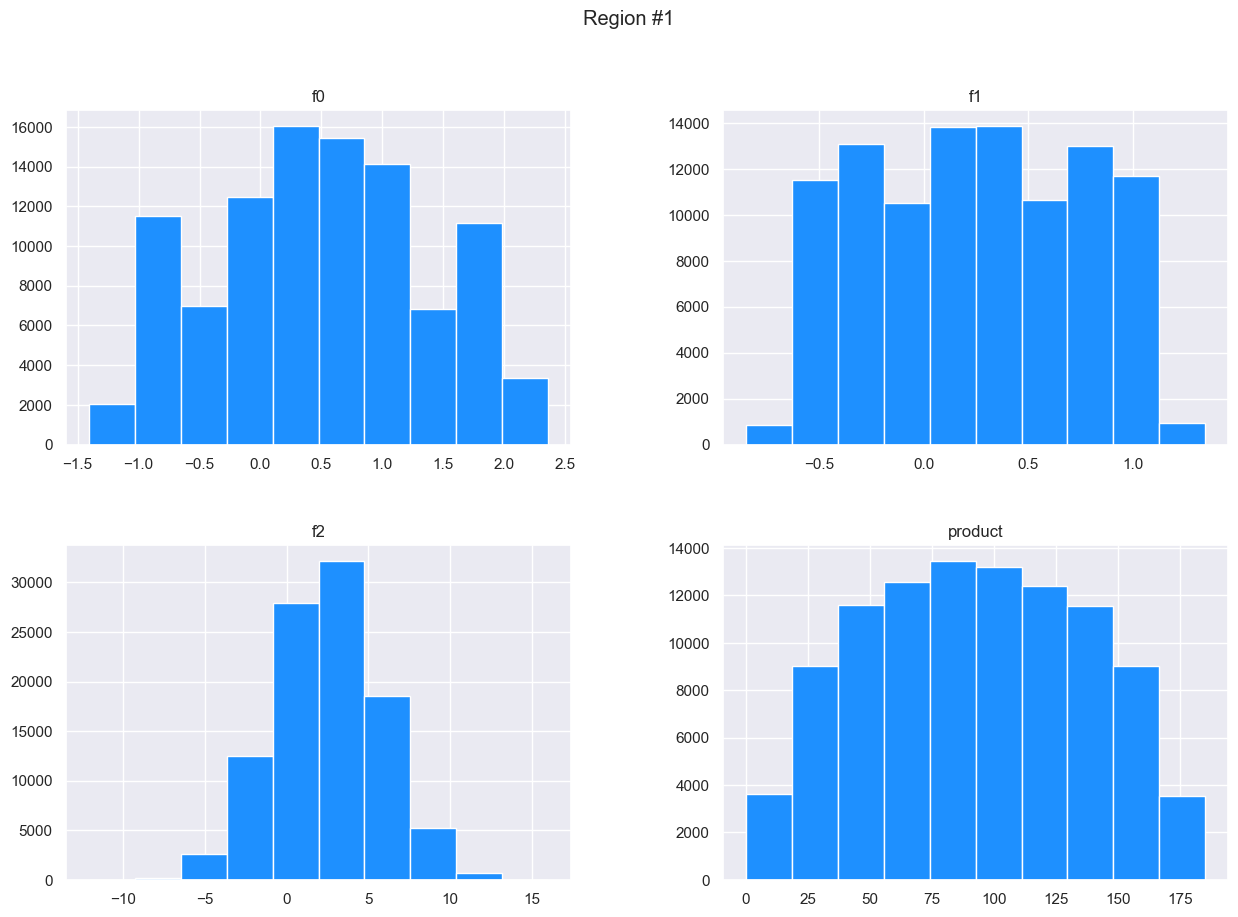

In [9]:
sns.set_theme(style="darkgrid")
geo_data_0.hist(figsize=(15, 10), color="dodgerblue")
plt.suptitle("Region #1")
plt.show()

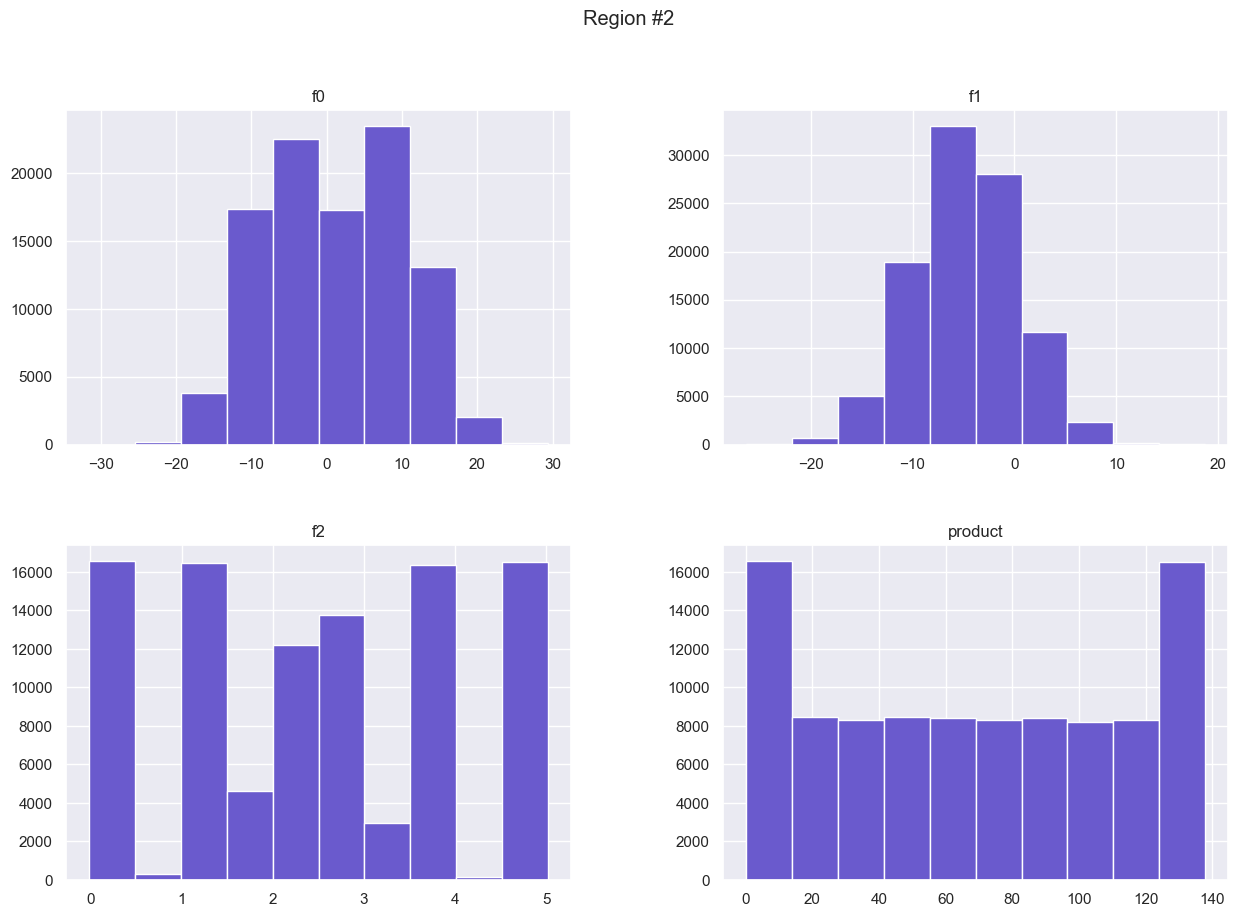

In [10]:
geo_data_1.hist(figsize=(15, 10), color="slateblue")
plt.suptitle("Region #2")
plt.show()

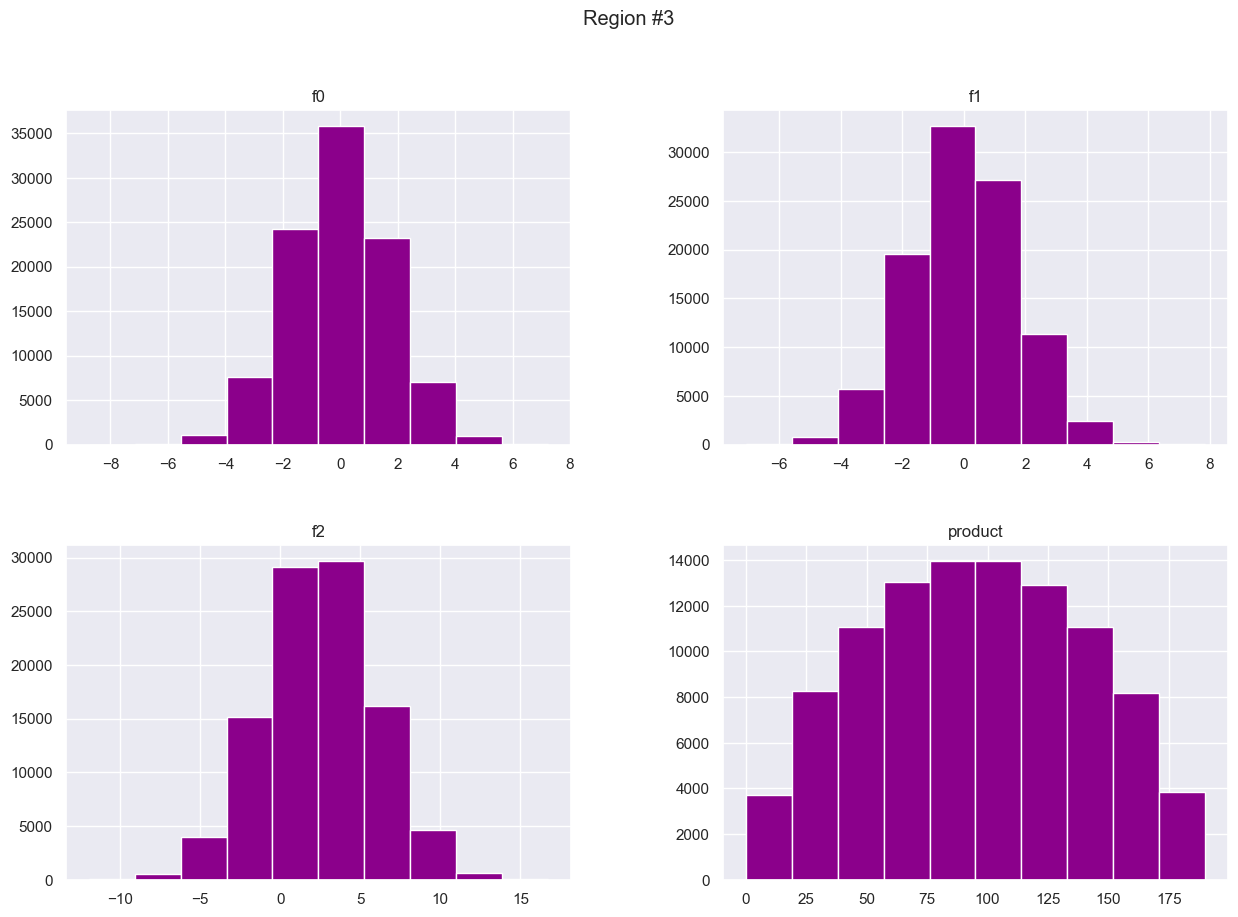

In [11]:
geo_data_2.hist(figsize=(15, 10), color="darkmagenta")
plt.suptitle("Region #3")
plt.show()

We see that the histograms have some differences between regions. In particular, for example, Region #3 is interesting because the histograms for all numeric columns resemble a normal distribution, which is not completely true about Region #1 and Region #2.

### Data preprocessing

Now, we get to preprocessing the data. Let's verify the number of missing values, duplicated rows and duplicated identifiers. For that we can write a function called `preprocess_data()`, which will check the DataFrame for the problems stated above and will accordingly adjust it. Specifically, here we will just remove all rows with missing values and duplicates. It should be noted that should duplicated rows or duplicated ids be found, we will keep the last duplicate. Since duplicates could have appeared due to additional measurements on the oil wells, we want to be able to have the latest information so we specify in such cases `keep="last"`.

In [12]:
def preprocess_data(
    data: pd.DataFrame,
    preprocess_nan_values: bool = False,
    preprocess_dup_rows: bool = False,
    preprocess_dup_ids: bool = False,
) -> None:
    """
    Preprocesses missing values, duplicated rows and
    duplicated identifiers in a DataFrame.

    In case of the aforementioned problems found, cleans
    a DataFrame from missing values, duplicated rows and
    duplicated ids.

    Args:
        data: DataFrame with information on oil wells with its
            identifiers and features.
        preprocess_nan_values: Boolean value indicating checking
            the data for missing values and adjusting it accordingly.
        preprocess_dup_rows: Boolean value indicating checking
            the data for identical rows and adjusting it accordingly.
        preprocess_dup_ids: Boolean value indicating checking
            the data for duplicated ids and adjusting it accordingly.

    Returns:
        Returns None. Displays a message in accordance with problems
        found. DataFrames are automatically adjusted for issues identified.
    """
    # Preprocessing missing values
    if preprocess_nan_values:
        nan_values_num = data.isnull().sum().sum()
        if nan_values_num == 0:
            print("No missing values found.")
        else:
            data.dropna(subset=data.columns, inplace=True)
            data.reset_index(drop=True, inplace=True)
            print(f"{nan_values_num:,} missing value(s) have been found and deleted.")

    # Preprocessing duplicated rows
    if preprocess_dup_rows:
        dup_rows_num = data.duplicated().sum()
        if dup_rows_num == 0:
            print("No duplicated rows found.")
        else:
            data.drop_duplicates(keep="last", inplace=True)
            data.reset_index(drop=True, inplace=True)
            print(f"{dup_rows_num:,} duplicated row(s) have been found and deleted.")

    # Preprocessing duplicated identifiers
    if preprocess_dup_ids:
        dup_ids_num = data["id"].duplicated().sum()
        if dup_ids_num == 0:
            print("No duplicated identifiers found.")
        else:
            data.drop_duplicates(subset="id", keep="last", inplace=True)
            data.reset_index(drop=True, inplace=True)
            print(
                f"{dup_ids_num:,} duplicated identifiers have been found and deleted."
            )

Now, let's apply this function to each DataFrame.

In [13]:
# Preprocessing DataFrame for Region #1
preprocess_data(
    data=geo_data_0,
    preprocess_nan_values=True,
    preprocess_dup_rows=True,
    preprocess_dup_ids=True,
)

No missing values found.
No duplicated rows found.
10 duplicated identifiers have been found and deleted.


In [14]:
# Preprocessing DataFrame for Region #2
preprocess_data(
    data=geo_data_1,
    preprocess_nan_values=True,
    preprocess_dup_rows=True,
    preprocess_dup_ids=True,
)

No missing values found.
No duplicated rows found.
4 duplicated identifiers have been found and deleted.


In [15]:
# Preprocessing DataFrame for Region #3
preprocess_data(
    data=geo_data_2,
    preprocess_nan_values=True,
    preprocess_dup_rows=True,
    preprocess_dup_ids=True,
)

No missing values found.
No duplicated rows found.
4 duplicated identifiers have been found and deleted.


We can see that there are no missing values and duplicated rows in the data but, however, the function has managed to find identical identifiers in the DataFrames, which it has been able to delete. As mentioned above, these ones could have appeared due to additional measurements on the oil wells so we deleted all such duplicates, except the last one.

### Correlation analysis

Now, let's conduct correlation analysis and make sure we do not have multicollinearity problem, under which Linear Regression generates unreliable results. We can conveniently plot correlation matrix as a heatmap by writing another function called `plot_corr_heatmap()`.

In [16]:
def plot_corr_heatmap(
    data: pd.DataFrame,
    annot_num_size: Optional[int] = None,
    colormap: Optional[Any] = None,
    upper_triangle: bool = False,
    lower_triangle: bool = False,
) -> Any:
    """
    Plots a heatmap of the correlation matrix.

    Args:
        data: DataFrame.
        annot_num_size: Font size of numbers inside the
            correlation matrix heatmap.
        colormap: Colormap applied to the heatmap.
        show_upper_triangle: Boolean value indicating showing
            the upper triangle of values of a correlation matrix
            heatmap.
        show_lower_triangle: Boolean value indicating showing
            the lower triangle of values of a correlation matrix
            heatmap.

    Returns:
        Returns an object of any type. Plots a full correlation matrix heatmap or
        an upper/lower triangle of a matrix.
    """
    corr_matrix = data.corr()

    # Showing upper/lower triangle of a matrix
    if upper_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.tril_indices_from(mask)] = True
    elif lower_triangle:
        mask = np.zeros_like(corr_matrix)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = None

    # Plotting a matrix
    corr_heatmap = sns.heatmap(
        corr_matrix,
        annot=True,
        mask=mask,
        annot_kws={"size": annot_num_size},
        cmap=colormap,
    )
    corr_heatmap.xaxis.tick_bottom()
    corr_heatmap.yaxis.tick_left()
    corr_heatmap.set(title="Correlation matrix")
    plt.show()

Let's consequently display heatmaps for correlation matrix for each DataFrame, where we will plot only the lower triangle of the matrix by specifying `lower_triangle=True`.

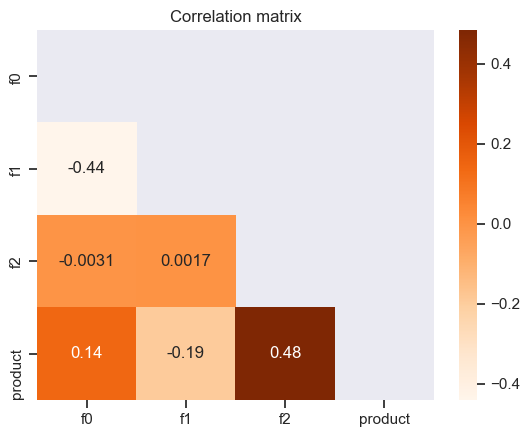

In [17]:
plot_corr_heatmap(data=geo_data_0, colormap="Oranges", lower_triangle=True)

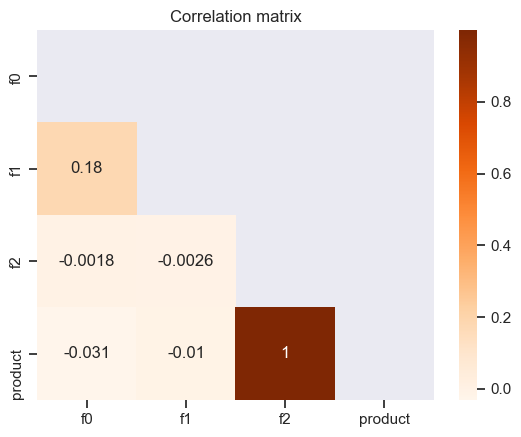

In [18]:
plot_corr_heatmap(data=geo_data_1, colormap="Oranges", lower_triangle=True)

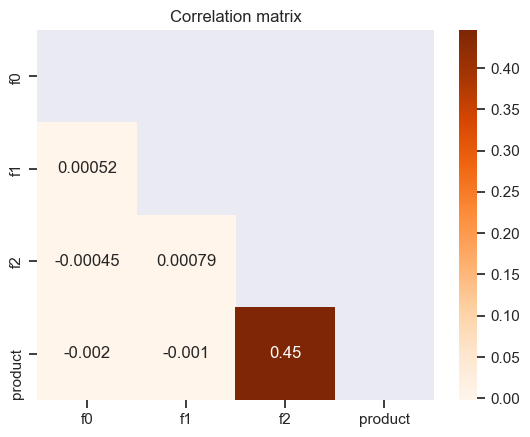

In [19]:
plot_corr_heatmap(data=geo_data_2, colormap="Oranges", lower_triangle=True)

We notice that features are not so strongly correlated between each other, thus signifying the fact that we should not be that concerned about multicolllinearity being present in the data. It should be noted that features `f0` and `f1` do not seem to correlate much with our target variable `product`, however, as far as `f2` is concerned, it showcases a pretty strong correlation with the target, which is especially the case for Region #2.

### Data split

The next step is to divide the data into separate datasets: training and validation. Before moving on to that, we will delete the columns that we will not need in the process of training the model. This only applies to the `id` column: we are not interested in any particular oil well, but the whole region, that is, the aggregation of data on these wells. Therefore, since oil well identifiers will not provide the model with any predictive power, we will get rid of this column. Let's do this in the most flexible way: provided that new relevant columns of the `object` type will not appear in the future, we can simply remove the `id` column by specifying the exclusion of columns of this type from the DataFrame.

In [20]:
# Filtering out irrelevant columns
geo_data_0 = geo_data_0[geo_data_0.select_dtypes(exclude="object").columns]
geo_data_1 = geo_data_1[geo_data_1.select_dtypes(exclude="object").columns]
geo_data_2 = geo_data_2[geo_data_2.select_dtypes(exclude="object").columns]

Let's check the changes made by printing the last 5 rows of the DataFrames.

In [21]:
display(geo_data_0.tail())
display(geo_data_1.tail())
display(geo_data_2.tail())

,f0,f1,f2,product
99985,0.971957,0.370953,6.075346,110.744026
99986,1.392429,-0.382606,1.273912,122.346843
99987,1.029585,0.018787,-1.348308,64.375443
99988,0.998163,-0.528582,1.583869,74.040764
99989,1.764754,-0.266417,5.722849,149.633246


,f0,f1,f2,product
99991,9.535637,-6.878139,1.998296,53.906522
99992,-10.160631,-12.558096,5.005581,137.945408
99993,-7.378891,-3.084104,4.998651,137.945408
99994,0.665714,-6.152593,1.000146,30.132364
99995,-3.426139,-7.794274,-0.003299,3.179103


,f0,f1,f2,product
99991,-1.777037,1.125220,6.263374,172.327046
99992,-1.261523,-0.894828,2.524545,138.748846
99993,-1.199934,-2.957637,5.219411,157.080080
99994,-2.419896,2.417221,-5.548444,51.795253
99995,-2.551421,-2.025625,6.090891,102.775767


Now we need to separate the features from the target, which in this case is contained in the `product` column, and then split the data. It is convenient to do this by writing a separate function `split_data()`, which will carry out such a separation task, and then divide the data into training and validation sets. Additionally, we will check the sets for the correct proportions. In this case, the data will be split based on the predefined values of `VALID_SET_SIZE` and `RANDOM_STATE`.

In [22]:
def split_data(
    data: pd.DataFrame, target_name: str = "product"
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Splits a DataFrame into training and validation sets.

    Given the data, separates features from a target and proceeds
    to splitting the data into training and validation data sets.
    Additionally, verifies the sizes of these sets for correctness
    of proportions.

    Args:
        data: DataFrame with information on oil wells with
            numeric features.
        target_name: Name of a target variable.

    Returns:
        A tuple of two pandas.DataFrame objects (training and validation
        features matrices) as well as two pandas.Series objects (training
        and validation target vectors).
    """
    # Separating features from target
    features = data.drop([target_name], axis=1)
    target = data[target_name]

    # Splitting data
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=VALID_SET_SIZE, random_state=RANDOM_STATE
    )

    # Checking correctness of proportions
    train_set_share = features_train.shape[0] / features.shape[0]
    valid_set_share = features_valid.shape[0] / features.shape[0]

    assert (np.round(train_set_share, 2) == TRAIN_SET_SIZE) & (
        np.round(valid_set_share, 2) == VALID_SET_SIZE
    ), "Incorrect proportions"

    return features_train, features_valid, target_train, target_valid

Now let's test this function on each of the 3 DataFrames. If the logic of the function was coded correctly, then we should not receive any messages about the `AssertionError`.

In [23]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split_data(
    data=geo_data_0
)

In [24]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(
    data=geo_data_1
)

In [25]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(
    data=geo_data_2
)

There were no errors, which means that we were able to correctly divide the data in 3 DataFrames into the corresponding data sets, while respecting the proportions.

**Conclusion**

This section allowed us to examine the data presented by 3 DataFrames, check the data for inconsistencies, and divide data into appropriate training and validation datasets. All actions were done as flexibly as possible, where basically we used manually written functions to avoid code duplication and for easier code viewing.

## Training

Now let's move on to training the model. In this case, we will use *LinearRegression*, where we will carry out the modeling process for each Region. In order not to duplicate the code, we will again write a function, which we will now call `make_predictions()` and which will train the model and make predictions for a specific Region. In order not to constantly pass to the function all 4 sets of data for each of the three Regions obtained at the previous stage, we can simply pass to the function a DataFrame for a specific Region (`data`) and the function according to which the data is divided. This is done by the `split_rule` parameter, which determines how data from the DataFrame should be split. Here, by default, the argument for this parameter will be `split_data()` function that has been written above. `make_predictions()` will output two vectors with real target data on the validation set and predictions made by the model on this set, as well as the value of the calculated *RMSE* for the trained model.

In [26]:
def make_predictions(
    data: pd.DataFrame,
    split_rule: Callable[
        ..., Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]
    ] = split_data,
) -> Tuple[pd.Series, pd.Series, float]:
    """
    Calculates predictions for the target variable
    on the validation set for a DataFrame.

    Args:
        data: DataFrame with information on oil wells with
            numeric features for a specific region.
        split_rule: A function responsible for splitting the
            data into training an validation data sets accordingly.

    Returns:
        Two pandas.Series objects with real validation data and computed
        predictions as well as floating point value of RMSE metric.
    """
    # Splitting DataFrame
    features_train, features_valid, target_train, target_valid = split_rule(data=data)

    # Training the model
    model = LinearRegression()
    model.fit(features_train, target_train)

    # Computing predictions on validation set
    predicted_values = model.predict(features_valid)

    # Saving validation predictions and real validation data
    predicted_values = pd.Series(predicted_values, index=target_valid.index)
    true_values = target_valid.copy()

    # Computed RMSE
    rmse = mean_squared_error(true_values, predicted_values, squared=False)

    return true_values, predicted_values, rmse

Now we can test this function on all three Regions, where we will also calculate the average values for the predicted reserves of oil for a particular region.

In [27]:
# Computing predictions and average value of predictions (Region #1)
product_true_0, product_predicted_0, rmse_0 = make_predictions(data=geo_data_0)
product_predicted_mean_0 = product_predicted_0.mean()

In [28]:
# Computing predictions and average value of predictions (Region #2)
product_true_1, product_predicted_1, rmse_1 = make_predictions(data=geo_data_1)
product_predicted_mean_1 = product_predicted_1.mean()

In [29]:
# Computing predictions and average value of predictions (Region #3)
product_true_2, product_predicted_2, rmse_2 = make_predictions(data=geo_data_2)
product_predicted_mean_2 = product_predicted_2.mean()

To understand what the function eventually calculated, let's look at what the real data, predictions and values of the *RMSE* metric look like for, for example, region 2.

In [30]:
compare_reg2 = pd.concat([product_true_1, product_predicted_1], axis=1)
compare_reg2.columns = ["product_true", "product_pred"]
display(compare_reg2.head())

,product_true,product_pred
71747,80.859783,82.662371
80489,53.906522,54.421351
2655,0.000000,0.550294
71170,110.992147,110.202674
91137,0.000000,1.239523


In [31]:
rmse_1

0.8877441757012706

As defined in the function itself, we get two objects of `pd.Series` type, as well as the `float` metric value of *RMSE*. We see predictions and real data for each row number in the validation set, which are essentially oil wells.

Let's combine the results into a table to analyze what happened in the end.

In [32]:
# Creating DataFrame columns
cols_compare = {
    "model": ["LinearRegression"],
    "rmse": [rmse_0, rmse_1, rmse_2],
    "prod_pred_mean": [
        product_predicted_mean_0,
        product_predicted_mean_1,
        product_predicted_mean_2,
    ],
}
# Creating a comparative table
df_compare = pd.DataFrame(
    cols_compare, index=["Region #1", "Region #2", "Region #3"]
).round(2)
df_compare

,model,rmse,prod_pred_mean
Region #1,LinearRegression,37.93,92.60
Region #2,LinearRegression,0.89,68.53
Region #3,LinearRegression,40.19,94.94


We observe the following. The results for Region 2 turned out to be the most accurate: the real data does not differ so much on average from the prediction. By the way, this is noticeable from the results of the output of predictions and correct answers a little higher, where, indeed, the predictions are quite close to the real data. As for other Regions, it is obvious that the deviations of predictions from real data are much higher there and, consequently, the error values of objects are higher. This fact is taken into account by the *RMSE* metric, which punishes the model for higher error values. Furthermore, if we look at the average values of predictions, these for Region #1 and Region #3 are pretty high, which is the result of the model overestimating real data. However, such results do not mean that we should immediately choose Region 2: we still need to calculate profits and analyze risks.

**Conclusion**

At this stage, a Linear Regression model was trained for each region. It was found that the predictions for Region #2 are the most accurate and close to the values of the real data from the validation sample, which cannot be said about the other two regions.

## Profit computation preparation

Now, let's calculate how much production is needed for the break-even development of a new well, that is, in other words, the volume of production at which zero profit will be achieved. The profit can be found as follows. The price per 1000 barrels, which is given in the constant variable we predefined as `REVENUE_PER_1000_BARRELS`, must be multiplied by the required volume of production. We compute the budget for the development of one well (one out of the 200 wells for which funds were allocated) and subtract it from the previous multiplication result. We only know the total budget `TOTAL_COST`, but it is determined for 200 wells that are planned to be developed, which allows us to find the cost of break-even development of one well.

In [33]:
# Computing break-even production level
break_even_prod = (TOTAL_COST / OIL_WELLS_SELECTED) / REVENUE_PER_1000_BARRELS
print("Break-even production level: {:.2f} (thousand barrels)".format(break_even_prod))

# Checking correctness of calculations
break_even_profit = REVENUE_PER_1000_BARRELS * break_even_prod - (
    TOTAL_COST / OIL_WELLS_SELECTED
)
assert break_even_profit == 0

Break-even production level: 111.11 (thousand barrels)


We see that for the break-even development of one well, such a well should produce about 111 thousand barrels on average. Let's put this data in the table and compare it with the average values of the predictions.

In [34]:
df_compare["prod_break_even"] = np.round(break_even_prod, 2)
display(df_compare)

,model,rmse,prod_pred_mean,prod_break_even
Region #1,LinearRegression,37.93,92.60,111.11
Region #2,LinearRegression,0.89,68.53,111.11
Region #3,LinearRegression,40.19,94.94,111.11


The break-even values turned out to be much higher than the average predictions, but this does not mean that there is no point in developing wells in these regions. We have to look at the profit that can be made in each of these Regions. To do this, we will write the function `compute_profit()`, which, based on the data for the Region (the `data` parameter) and the correct answers /predictions obtained at the previous stage (the `prediction_rule` parameter), will calculate the profit based on the 200 most promising wells from the point of view of the model. It should be noted that the predictions will be calculated by default by the previously defined function `make_predictions()`, where we will also need correct answers on the validation sample, since we will calculate the profit based on real data, but on the wells selected by the model. 

Additionally, we will include in this function the ability to calculate profits using the *Bootstrap* technique, which will be determined by the `bootstrap` parameter. In this case, when calculating profit by this method, the function will return not the profit value, but a collection of profit values calculated for each of the `NUM_BOOTSTRAP_SAMPLE` samples. We will proceed as follows: for each iteration, we will randomly select 500 values from the predicted validation sample, and then, based on the predictions, we will select the 200 most profitable wells from the point of view of the model, which we will take from the real validation sample to calculate the profit.

In [35]:
def compute_profit(
    data: pd.DataFrame,
    prediction_rule: Callable[
        ..., Tuple[pd.Series, pd.Series, float]
    ] = make_predictions,
    bootstrap: bool = False,
) -> Union[pd.Series, float]:
    """
    Computes profits for oil wells selected by
    the model for a specific region with Bootstrap
    functionality added.

    Args:
        data: DataFrame with data on oil wells
            development for a specific region.
        prediction_rule: Function for computing
            predictions.
        bootstrap: Indicator of applying Bootstrap
            procedure for computing profits.

    Returns:
        Returns float number in case of not using Boostrap
        for computing profits. When using Bootstrap, returns
        pd.Series object.
    """
    # Computing predictions and selecting real data
    true_values, predicted_values, _ = prediction_rule(data=data)

    # Applying Bootstrap procedure
    if bootstrap:
        profits = []
        state = np.random.RandomState(RANDOM_STATE)
        for _ in range(NUM_BOOTSTRAP_SAMPLES):
            # Sampling random 500 objects from predictions
            select_500_predictions = predicted_values.sample(
                500, replace=True, random_state=state
            )
            # Determining top-200 oil wells
            top_predictions = select_500_predictions.sort_values(ascending=False).head(
                200
            )
            # Computing total production level on top-200 oil wells
            top_true_values = true_values.loc[top_predictions.index]
            barrels = top_true_values.sum()
            # Computing profits on top-200 oil wells
            profit = REVENUE_PER_1000_BARRELS * barrels - TOTAL_COST
            # Adding computed profit to a collection of profits
            profits.append(profit)

        profits = pd.Series(profits)

        return profits

    # Computing profit (no Bootstrap)
    top_200_predictions = predicted_values.sort_values(ascending=False).head(200)
    top_true_values = true_values.loc[top_200_predictions.index]
    barrels = top_true_values.sum()
    profit = REVENUE_PER_1000_BARRELS * barrels - TOTAL_COST

    return profit

Let's use this function to calculate profits by region (so far without *Bootstrap*).

In [36]:
# Computing profit for each region
profit_0 = compute_profit(data=geo_data_0)
profit_1 = compute_profit(data=geo_data_1)
profit_2 = compute_profit(data=geo_data_2)

Let's add the results to a new table.

In [37]:
# Creating a table for profits
cols = {"profit": [profit_0, profit_1, profit_2]}

profit_df = pd.DataFrame(data=cols, index=["Region #1", "Region #2", "Region #3"])
profit_df["profit"] = np.ceil(profit_df["profit"]).astype("int64")
profit_df.style.format({"profit": "{:,}".format})

,profit
Region #1,"2,990,084,536"
Region #2,"2,415,086,697"
Region #3,"2,426,209,622"


Now we see that from the point of view of models, Region #1 is the most promising investment, which is evident from the profit of about 3 billion rubles. In this case, we just took the top 200 wells according to the model and of course got quite large numbers. However, if we iteratively randomly selected samples of well production values, we could get different results, which will be done in the next step.

**Conclusion**

At this stage, we have calculated the profit for each Region for the top 200 wells that were selected by Linear Regression model. The results showed that Region #1 is a potentially profitable place to develop wells on the condition that we consider the top 200 wells.

## Computing profits and risks

At this stage, we need to conduct a profit and risk analysis. To do this, we use the *Bootstrap* technique, where we consider 1000 samples, the number of which is defined in the constant `NUM_BOOTSTRAP_SAMPLES`. First, we will get collections of profit values for 1000 samples, and then we will calculate the average profit values.

In [38]:
# Computing profits for regions using Bootstrap
profits_boot_0 = compute_profit(data=geo_data_0, bootstrap=True)
profits_boot_1 = compute_profit(data=geo_data_1, bootstrap=True)
profits_boot_2 = compute_profit(data=geo_data_2, bootstrap=True)

# Computing average profits for regions
profit_mean_0 = profits_boot_0.mean()
profit_mean_1 = profits_boot_1.mean()
profit_mean_2 = profits_boot_2.mean()

Now let's look at unprofitable wells with negative profits and calculate the percentage of wells for each region that are unprofitable.

In [39]:
# Computing loss risk for each region
loss_risk_0 = profits_boot_0[profits_boot_0 < 0].shape[0] / profits_boot_0.shape[0]
loss_risk_1 = profits_boot_1[profits_boot_1 < 0].shape[0] / profits_boot_1.shape[0]
loss_risk_2 = profits_boot_2[profits_boot_2 < 0].shape[0] / profits_boot_2.shape[0]

Let's move on to calculating the confidence interval. Note that we will use 95% as the confidence level, which is specified in the constant `CONFIDENCE_LEVEL`.

In [40]:
# Defining quantiles for computing interval bounds
lower_point = (1 - CONFIDENCE_LEVEL) / 2
upper_point = 1 - lower_point

# Computing interval bounds
lower_0, upper_0 = profits_boot_0.quantile(lower_point), profits_boot_0.quantile(
    upper_point
)
lower_1, upper_1 = profits_boot_1.quantile(lower_point), profits_boot_1.quantile(
    upper_point
)
lower_2, upper_2 = profits_boot_2.quantile(lower_point), profits_boot_2.quantile(
    upper_point
)

Let's put all the results in the table.

In [41]:
# Creating a table with Bootstrap results
cols = {
    "profit_boot_mean": [profit_mean_0, profit_mean_1, profit_mean_2],
    "lower": [lower_0, lower_1, lower_2],
    "upper": [upper_0, upper_1, upper_2],
    "loss_risk": [loss_risk_0, loss_risk_1, loss_risk_2],
}
df = pd.DataFrame(data=cols, index=["Region #1", "Region #2", "Region #3"])

# Types conversions
df["profit_boot_mean"] = np.ceil(df["profit_boot_mean"]).astype("int64")
df["lower"] = np.ceil(df["lower"]).astype("int64")
df["upper"] = np.ceil(df["upper"]).astype("int64")

# Formating a table
df.style.format(
    {
        "profit_boot_mean": "{:,}".format,
        "lower": "{:,}".format,
        "upper": "{:,}".format,
        "loss_risk": "{:.1%}".format,
    }
)

,profit_boot_mean,lower,upper,loss_risk
Region #1,"399,953,489","-130,263,689","916,732,139",6.6%
Region #2,"441,524,244","58,209,064","838,801,421",1.4%
Region #3,"303,793,869","-226,395,997","861,077,923",12.3%


Now, based on the established threshold value of the risk of losses, we will choose the most favorable regions for investment, and then among them we will choose the region with the highest average profit.

In [42]:
# Selecting regions by loss risk
df_final = df[df["loss_risk"] < LOSS_RISK_THRESHOLD]

# Selecting the most favorable region
df_final = df_final[
    df_final["profit_boot_mean"] == np.max(df_final["profit_boot_mean"])
]

# Printing final results
df_final = df_final.style.format(
    {
        "profit_boot_mean": "{:,}".format,
        "lower": "{:,}".format,
        "upper": "{:,}".format,
        "loss_risk": "{:.1%}".format,
    }
)
display(df_final)
print("Region chosen: {}.".format(df_final.index[0]))

,profit_boot_mean,lower,upper,loss_risk
Region #2,"441,524,244","58,209,064","838,801,421",1.4%


Region chosen: Region #2.


So, we see that even after choosing the regions with the lowest level of risk, we have only Region #2 left. Moreover, the average profit of this region is the highest among other regions, which allows us to make a choice.

**Conclusion**

At this stage, we have performed a profit and risk analysis using statistical data analysis and *Bootstrap* techniques. Based on the results of the analysis, we chose Region #2, which, in addition to the favorable value of the *RMSE* metric, has a low risk of losses, as well as the maximum value of average profit among others.

## General conclusion

This study aimed to select the most favorable region for the development of 200 wells. Having data on 3 regions and the corresponding wells, we have studied, preprocessed and prepared data for use in machine learning algorithms, which helped to make the choice of a potentially profitable place. After training Linear Regression model for all regions, we were able to calculate the profit, both without and with the *Bootstrap* technique, where we selected Region #2 as a place to develop new wells. In addition to the attractive values of the *RMSE* metric, this region is characterized by a fairly high profit, as well as a low loss rate of 1.4%.

In the future, it is advisable that the datasets should be checked more carefully for the uniqueness of each object and their values without any duplications so that we can immediately focus on achieving the results of the study.